# Introduction

Assuming that REJ1034+396 is an EMRI source which may be relevant for observation by LISA in 2030s, we estimate, first, the mass of the system's CO, and then the SNR of the source in LISA band.

In [12]:
import os
from matplotlib import pyplot as plt
import numpy as np
import time
import sys
import cupy as cp
from scipy.special import jn
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import scipy.special as sps 

#=== 5PN AAK imports ================

from few.trajectory.inspiral import EMRIInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux, GenerateEMRIWaveform
from few.utils.utility import (get_overlap, 
                               get_mismatch, 
                               get_fundamental_frequencies, 
                               get_separatrix, 
                               get_mu_at_t, 
                               get_p_at_t, 
                               get_kerr_geo_constants_of_motion,
                               xI_to_Y,
                               Y_to_xI)

from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum
from few.utils.constants import *
from few.summation.aakwave import AAKSummation
from few.waveform import Pn5AAKWaveform, AAKWaveformBase

traj = EMRIInspiral(func='pn5')

In [13]:
#=== constants =========================

G = 6.67259e-11
C = 299792458.
SM = 1.98892e30
SMsec = G*SM/C/C/C
GPC = 3.0856775807e25
GPCsec = GPC/C
YR = 31558149.8
AU = 1.4959787066e11
AUsec = AU/C
HS3 = np.sqrt(3)/2.
L = 2.5e9

#definitions of constants taken from FEW package
MSUN = 1.98848e30 #Mass of sun in SI
YRSID = 31558149.763545603 #seconds in one year 
G = 6.674080e-11 #Gravitational constant in SI
c = 299792458. #speed of light in SI
Gpc = 3.0856775814913674e+25 #1 Gigaparsec in SI
pi = np.pi 
#emm = (M*MSUN*mu*MSUN)**(3/5)/(M*MSUN+mu*MSUN)**(1/5) #chirp mass in SI units
H0 = 70e6 #Hubble constant in m/s/Gpc

In [14]:
def Keplerian_p_from_f(M, mu, f_orb_0, e0):
    return c**2*(1-e0**2)/(2*np.pi*f_orb_0*G*(M+mu)*MSUN)**(2/3)

def f_from_Keplerian_p(M, mu, p, e0):
    return (c**2*(1-e0**2)/p)**(3/2)/(2*np.pi*G*(M+mu)*MSUN)

def getdist(z):
    return c*z/H0

### Setting up the optimization

In [15]:
# Initializing waveform generator

#defining model parameters

use_gpu = True

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e6),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=use_gpu)

# set initial parameters (default parameters in FEW AAK Documentation)
traj = EMRIInspiral(func='pn5')

# {M, a, e0, T_1, T_2} drawn from a probability distribution

In [16]:
def neglikelihood(theta):
    #theta is the n-dimensional vector of variable parameters
    
    #in this analysis, theta = [mu]

    #calculating the trajectory for given mu
    p0 = Keplerian_p_from_f(M, theta, f1_measured, e0)
    
    trajectory = traj(M, theta, a, p0, e0, Y0, T = detection2-detection1,max_init_len=int(1e6))
    
    f1 = f_from_Keplerian_p(M, theta, trajectory[1][0], e0)
    f2 = f_from_Keplerian_p(M, theta, trajectory[1][-1], e0)
    
    fdot_theoretical = (f2-f1)/(detection2-detection1)
    
    return -(-(f_dot - fdot_theoretical)**2)

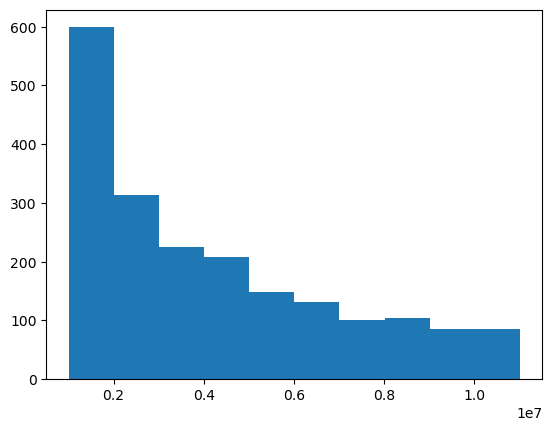

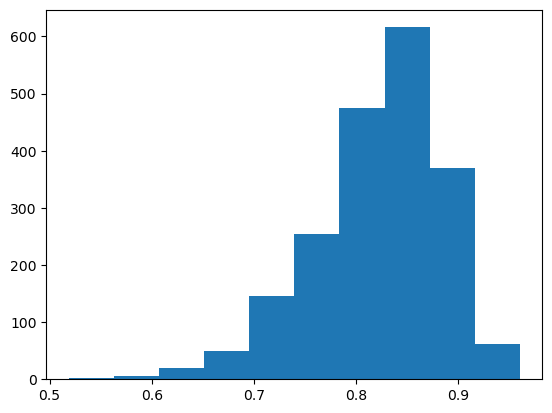

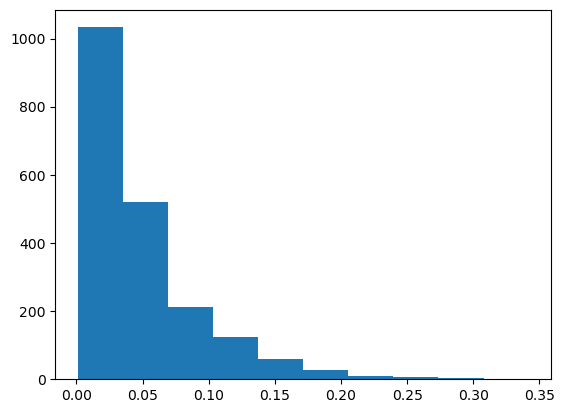

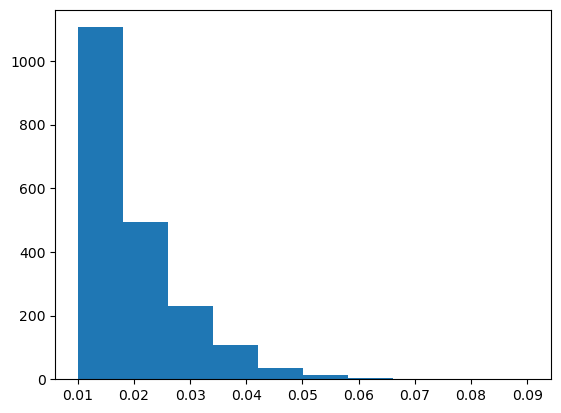

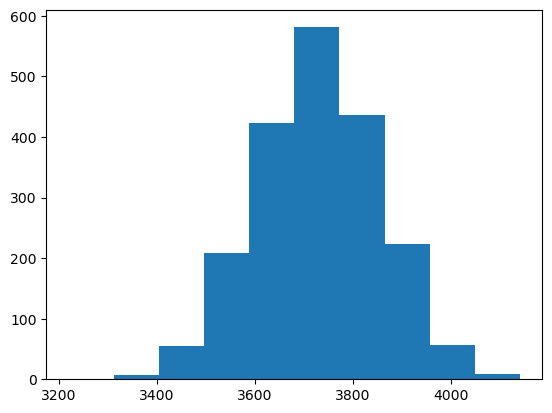

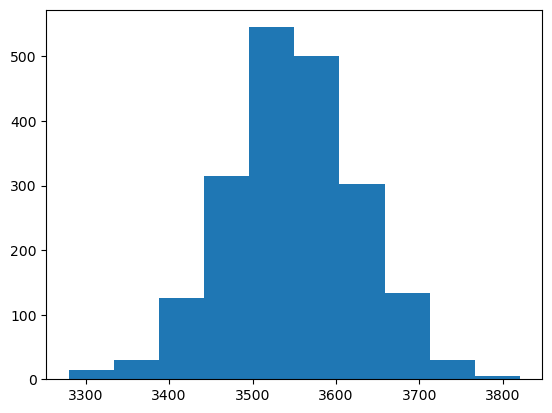

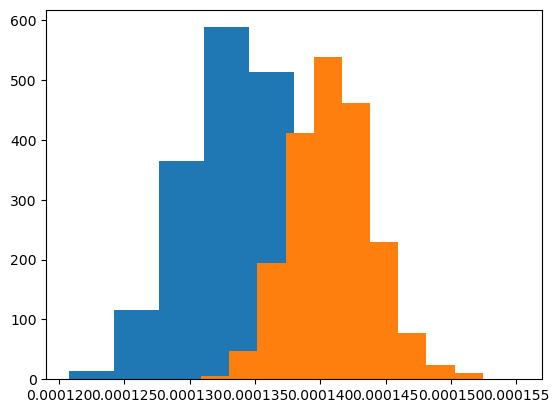

In [105]:
#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
np.random.seed(42)
from scipy.stats import expon, norm, uniform, skewnorm
from getdist import plots, MCSamples
import numpy as np

#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
np.random.seed(42)
from scipy.stats import expon, norm, uniform, skewnorm

#number of samples drawn
N = 2000

#redshifted MBH mass #####################################
#M_samples = norm.rvs(size=N,loc=2.5e6,scale=0.7e6)*(1+z)

log10M_samples = 6+uniform.rvs(size=N)*(1+z)

M_samples = 10**log10M_samples

plt.hist(M_samples)
plt.show()

#spin ####################################################
mean = 0.9
scale = 0.1

a_samples = skewnorm.rvs(-4,size=N,loc=mean,scale=scale) # uncertainty: Gamma[mean=0.9,var=0.01]
#a_samples = 1.9*(0.5-uniform.rvs(size=N))
#a_samples = a_samples[a_samples<1]
plt.hist(a_samples)
plt.show()

#eccentricity ############################################
mean = 0.1
scale = 0.05

e0_samples = expon.rvs(size=N,scale=scale,loc=1e-3) # uncertainty: Gamma[mean=0.1,var=0.001]
#e0_samples = e0_samples[e0_samples>0.0]
#e0_samples = np.zeros(N)

plt.hist(e0_samples)
plt.show()

#inc ######################################################
scale = 0.01

inc = expon.rvs(size=N,scale=scale,loc=0.01)
Y0_samples = np.cos(inc)

plt.hist(inc)
plt.show()

#periodicity ##############################################

detection1 = 2007
detection2 = 2018

T_detector_det1 = norm.rvs(size=N,loc=3730,scale=130) #in seconds, Vol 455| 18 September 2008| doi:10.1038/nature07277
plt.hist(T_detector_det1)
plt.show()

f1_samples = 1/(2*T_detector_det1) #Hz


T_detector_det2 = norm.rvs(size=N,loc=3550,scale=80) #in seconds, https://arxiv.org/pdf/2005.05857.pdf
plt.hist(T_detector_det2)
plt.show()

f2_samples = 1/(2*T_detector_det2) #Hz

plt.hist(f1_samples)
plt.hist(f2_samples)
plt.show()

#sky location #############################################

qS = 159*np.pi/180 #159 degrees from Newton-XMM open data
phiS = 40*np.pi/180 #40 degrees from Newton-XMM open data
qK = 0.2 #randomized
phiK = 0.4 #randomized

### Evaluation Cell -- Skip ahead if data is already available

In [ ]:
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.optimize import minimize_scalar

filename = 'Msamples_OOM'

x0 = 50.
mu_samples = []

samples_bool = []

for i in tqdm(range(len(M_samples))):
    if f1_samples[i] < f2_samples[i]:
        
        samples_bool.append(True)
        
        M = M_samples[i]
        a = a_samples[i]
        e0 = e0_samples[i]
        Y0 = Y0_samples[i]
        f1_measured = f1_samples[i]
        f2_measured = f2_samples[i]
        f_dot = (f2_measured - f1_measured)/((detection2-detection1)) #Hz/yr
        
        print(M,a,e0,f1_measured,f2_measured,f_dot,'\n')
        res = minimize_scalar(neglikelihood, bracket=(0.01,1000.), method='Brent')
        #print(res.x)
        mu_samples.append(res.x/(1+z))
        
        np.savetxt(f'mu_{filename}.txt',mu_samples)
            
    else:
        samples_bool.append(False)
        

mu_samples = np.array(mu_samples)
np.savetxt(f'mu_{filename}.txt',mu_samples)

### We require that f2 > f1 in our evolution trajectory, filters out handful of datapoints

In [106]:
filename = 'Msamples_OOM'

samples_bool = []

for i in range(len(M_samples)):
    if f1_samples[i] < f2_samples[i]:
        samples_bool.append(True)
    else:
        samples_bool.append(False)
        
M_samples = M_samples[samples_bool]
a_samples = a_samples[samples_bool]
e0_samples = e0_samples[samples_bool]
Y0_samples = Y0_samples[samples_bool]
f1_samples = f1_samples[samples_bool]
f2_samples = f2_samples[samples_bool]

f_dot_samples = (f2_samples - f1_samples)/((detection2-detection1))

print(len(M_samples))

1774


1774
45.92066596387755
35.02318415807927


(array([0.00957434, 0.00711938, 0.0120293 , 0.0115383 , 0.01522074,
        0.01374777, 0.0179212 , 0.01227479, 0.01644822, 0.01399326,
        0.01055632, 0.01472975, 0.01546624, 0.01644822, 0.01276578,
        0.01595723, 0.0115383 , 0.01325678, 0.01031083, 0.00932884,
        0.01129281, 0.01055632, 0.01080182, 0.01006533, 0.00957434,
        0.00810136, 0.00540091, 0.00662839, 0.00736488, 0.0056464 ,
        0.0056464 , 0.00761037, 0.00490992, 0.00466442, 0.00515541,
        0.00368244, 0.00441893, 0.00319145, 0.00490992, 0.00441893,
        0.00196397, 0.00147298, 0.00270045, 0.00147298, 0.00294595,
        0.00171847, 0.00245496, 0.00171847, 0.00147298, 0.00220946,
        0.00098198, 0.00098198, 0.00049099, 0.00220946, 0.00147298,
        0.00147298, 0.00098198, 0.00073649, 0.00147298, 0.00098198,
        0.00098198, 0.0002455 , 0.0002455 , 0.00049099, 0.00049099,
        0.00098198, 0.0002455 , 0.00049099, 0.00049099, 0.        ,
        0.0002455 , 0.00098198, 0.0002455 , 0.  

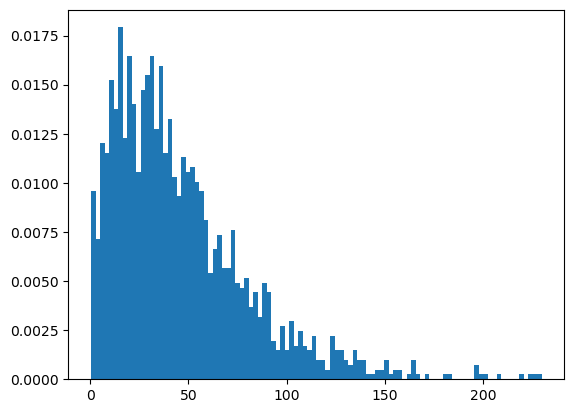

In [107]:
import numpy as np
import matplotlib.pyplot as plt

filename = 'Msamples_OOM'

mu_samples = np.loadtxt(f'mu_{filename}.txt')
print(len(mu_samples))
print(np.mean(mu_samples))
print(np.std(mu_samples))
plt.hist(mu_samples,density=True,bins=100)

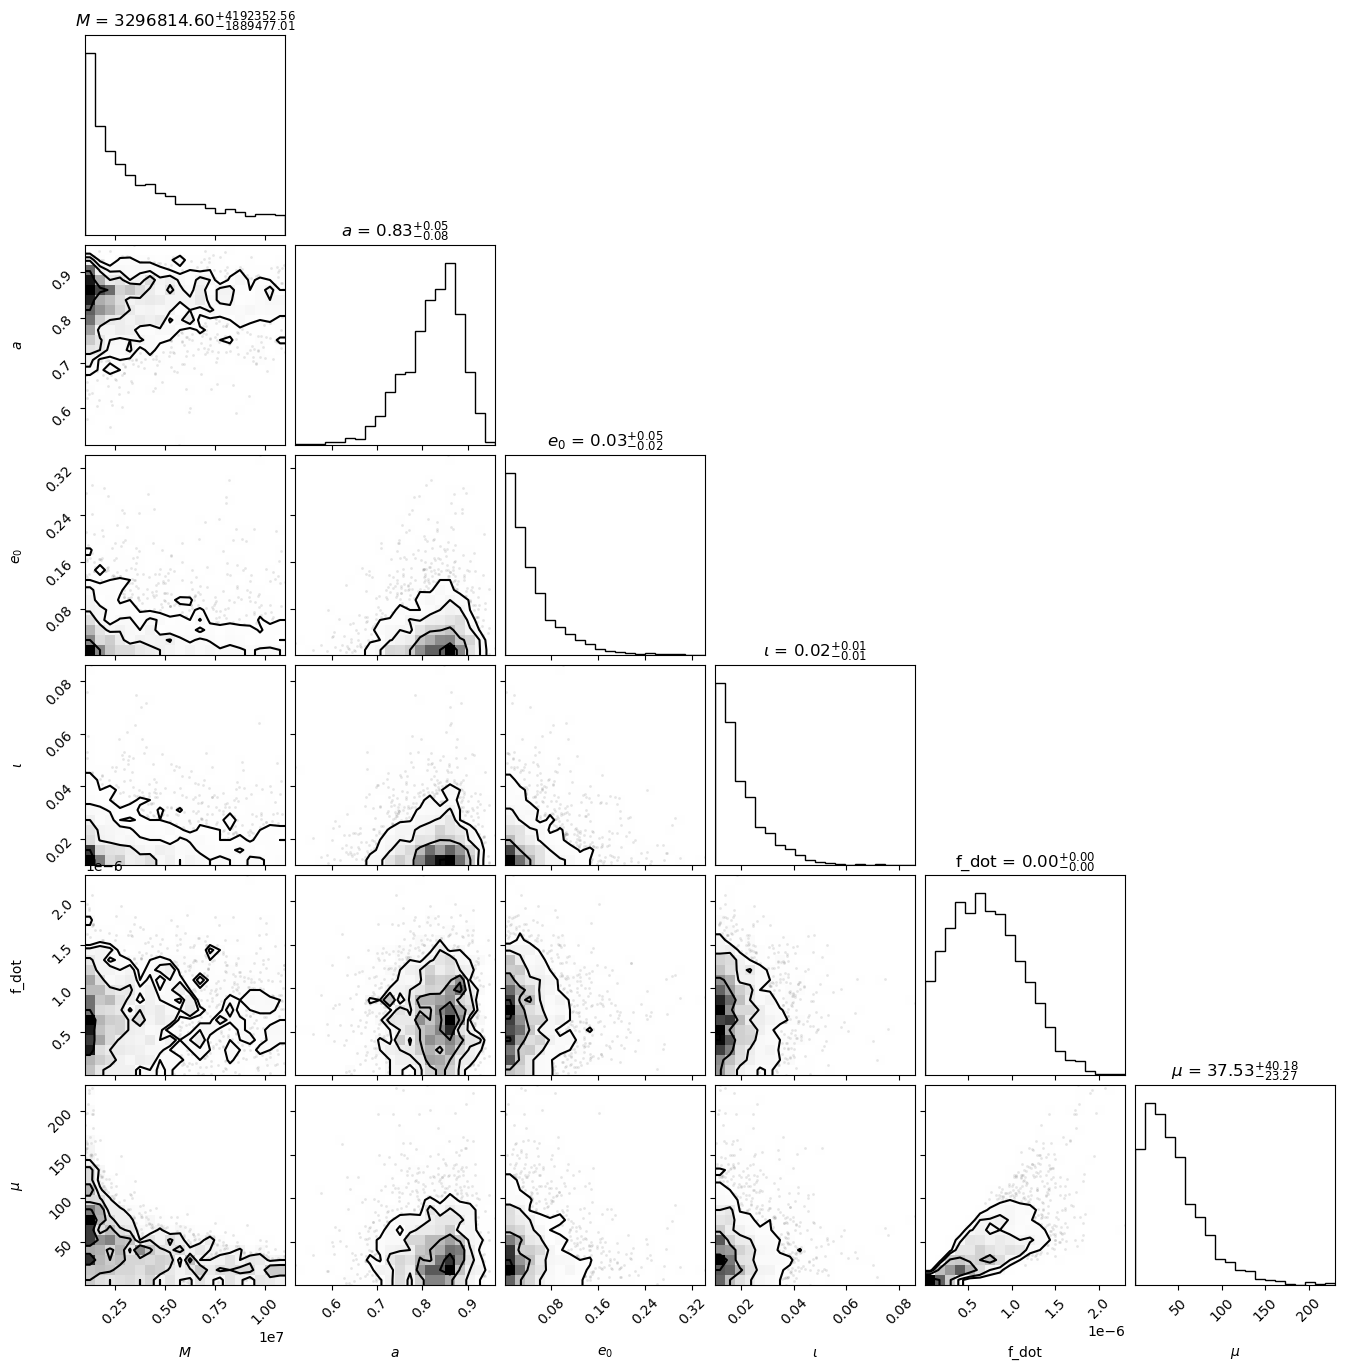

In [108]:
import corner

mu_samples = np.loadtxt(f'mu_{filename}.txt')

samples = np.stack((M_samples,a_samples,e0_samples,
                    np.arccos(Y0_samples),f_dot_samples,mu_samples),axis=1)

figure = corner.corner(samples,
                       range=[(min(M_samples),max(M_samples)),
                             (min(a_samples),max(a_samples)),
                             (min(e0_samples),max(e0_samples)),
                             (min(np.arccos(Y0_samples)),max(np.arccos(Y0_samples))),
                             (min(f_dot_samples),max(f_dot_samples)),
                             (min(mu_samples),max(mu_samples))],
                       labels=[r"$M$", r"$a$", r"$e_0$", r"$\iota$", r"f_dot", r"$\mu$"],show_titles=True, title_kwargs={"fontsize": 12})

figure.savefig(f'mudist_{filename}.png')

# 3. Obtaining a corresponding SNR distribution

### Now, we have samples for {M, mu, a, e0}, while p0, qS, phiS are fixed by the EM observations of RE J1034+396 and inc = 0 is assumed.

We forward evolve the trajectory to LISA START time and use the p0_LISA, e0_LISA values here as our LISA waveform calculation starting parameters.

Then, using samples of [M, mu, a, p0_LISA, e0_LISA, Y0, dist, qS, phiS, qK, phiK], we calculate the LISA SNR distribution of RE J1034+396.

In [54]:
#defining Sensitivity curve (for 1 year) 
def sensitivity(f):
    
    #Defining supporting functions
    L = 2.5e9 #m
    fstar = 19.09e-3 #Hz
    
    P_OMS = (1.5e-11**2)*(1+(2e-3/f)**4) #Hz-1
    P_acc = (3e-15**2)*(1+(0.4e-3/f)**2)*(1+(f/8e-3)**4) #Hz-1
    
    #S_c changes depending on signal duration (Equation 14 in 1803.01944)
    #for 1 year
    alpha = 0.171
    beta = 292
    kappa = 1020
    gamma = 1680
    fk = 0.00215
    #log10_Sc = (np.log10(9)-45) -7/3*np.log10(f) -(f*alpha + beta*f*np.sin(kappa*f))*np.log10(np.e) + np.log10(1 + np.tanh(gamma*(fk-f))) #Hz-1 
    
    A=9e-45
    Sc = A*f**(-7/3)*np.exp(-f**alpha+beta*f*np.sin(kappa*f))*(1+np.tanh(gamma*(fk-f)))
    
    return (10/(3*L**2))*(P_OMS+4*(P_acc)/((2*np.pi*f)**4))*(1 + 6*f**2/(10*fstar**2))+Sc

#Defining the inner product (this runs on the GPU)
from cupy.fft import rfft, rfftfreq

def inner_product(a,b):
    #Taking the FFTs of a and b
    n = max((len(a),len(b)))
    f = rfftfreq(n)/dt
    df = 1/(n*dt)
    atilde_real = rfft(a.real*dt, n=n)[1:]
    btilde_real = rfft(b.real*dt, n=n)[1:]

    plus_prod = cp.conj(atilde_real)@(btilde_real/sensitivity(f[1:]))

    atilde_imag = rfft(a.imag*dt, n=n)[1:]
    btilde_imag = rfft(b.imag*dt, n=n)[1:]

    cross_prod = cp.conj(atilde_imag)@(btilde_imag/sensitivity(f[1:]))
    return 4*df*cp.real(plus_prod+cross_prod)

ModuleNotFoundError: No module named 'cupy.fft'

### Evaluation Cell -- Skip Ahead if Data Available

In [ ]:
# Initializing waveform generator

#defining model parameters

use_gpu = True

# keyword arguments for inspiral generator (RunKerrGenericPn5Inspiral)
inspiral_kwargs = {
    "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
    "max_init_len": int(1e6),  # all of the trajectories will be well under len = 1000
}

# keyword arguments for summation generator (AAKSummation)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": False,
}

wave_generator = Pn5AAKWaveform(inspiral_kwargs=inspiral_kwargs, sum_kwargs=sum_kwargs, use_gpu=use_gpu)

# set initial parameters (default parameters in FEW AAK Documentation)
traj = EMRIInspiral(func='pn5')

T0 = 2007
T_LISA_START = 2037
T_LISA_END = 2041

T_EVOLVE = T_LISA_START - T0

T_LISA = T_LISA_END - T_LISA_START

dt = 10.

SNR = np.zeros(len(M_samples),dtype=np.float64)

p0_LISA_range = []

for i in tqdm(range(len(M_samples))):

    M = M_samples[i]
    a = a_samples[i]
    e0 = e0_samples[i]
    Y0 = Y0_samples[i]
    mu = mu_samples[i]
    f1_measured = f1_samples[i]

    p0 = Keplerian_p_from_f(M, mu, f1_measured, e0)

    dist = getdist(z)

    qS = qS
    phiS = phiS
    qK = qK
    phiK = phiK

    trajectory = traj(M, mu, a, p0, e0, Y0, T=T_EVOLVE, max_init_len=int(1e6))
    #trajectory_sum.append(trajectory[1])

    p0_LISA = trajectory[1][-1]
    
    p0_LISA_range.append(p0_LISA)
    
    e0_LISA = trajectory[2][-1]
    Y0_LISA = trajectory[3][-1]

    print(M,mu,a,p0_LISA,e0_LISA,Y0_LISA)

    if p0_LISA >= 4.0:

        h = wave_generator(M, mu, a, p0_LISA, e0_LISA, Y0_LISA, qS = qS, phiS = phiS, qK = qK, phiK = phiK, dist = dist,
                                 Phi_phi0=0.0, Phi_theta0=0.0, Phi_r0=0.0, mich=True, dt=10., T=T_LISA)
 
        SNR[i] = np.sqrt(inner_product(h,h)).real

        np.savetxt(f'SNR_{filename}.txt',SNR)

np.savetxt(f'SNR_{filename}.txt',SNR)


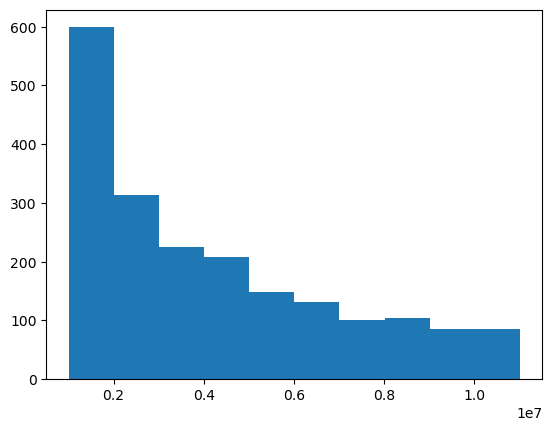

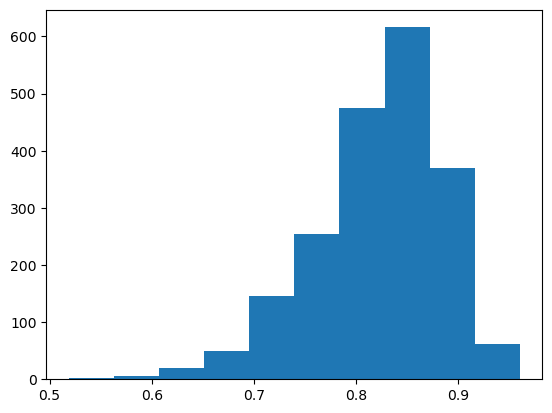

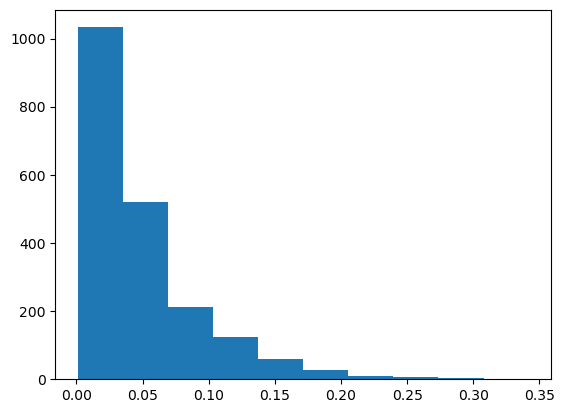

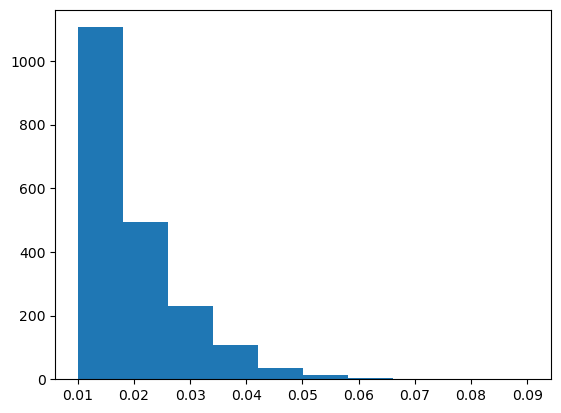

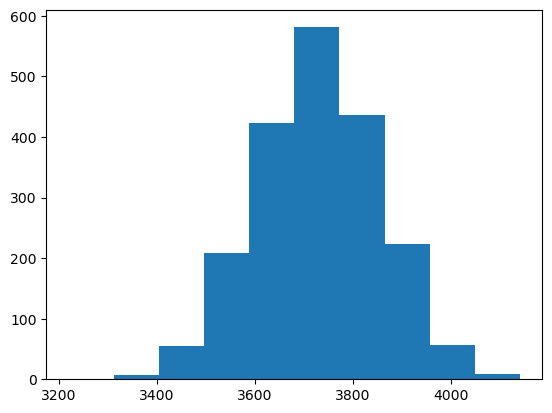

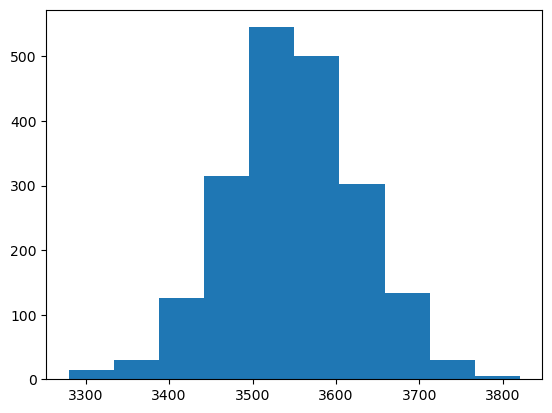

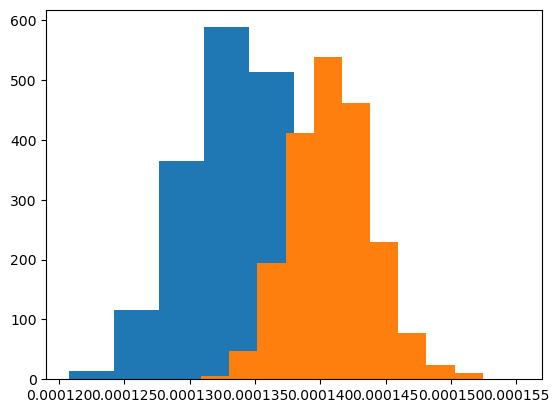

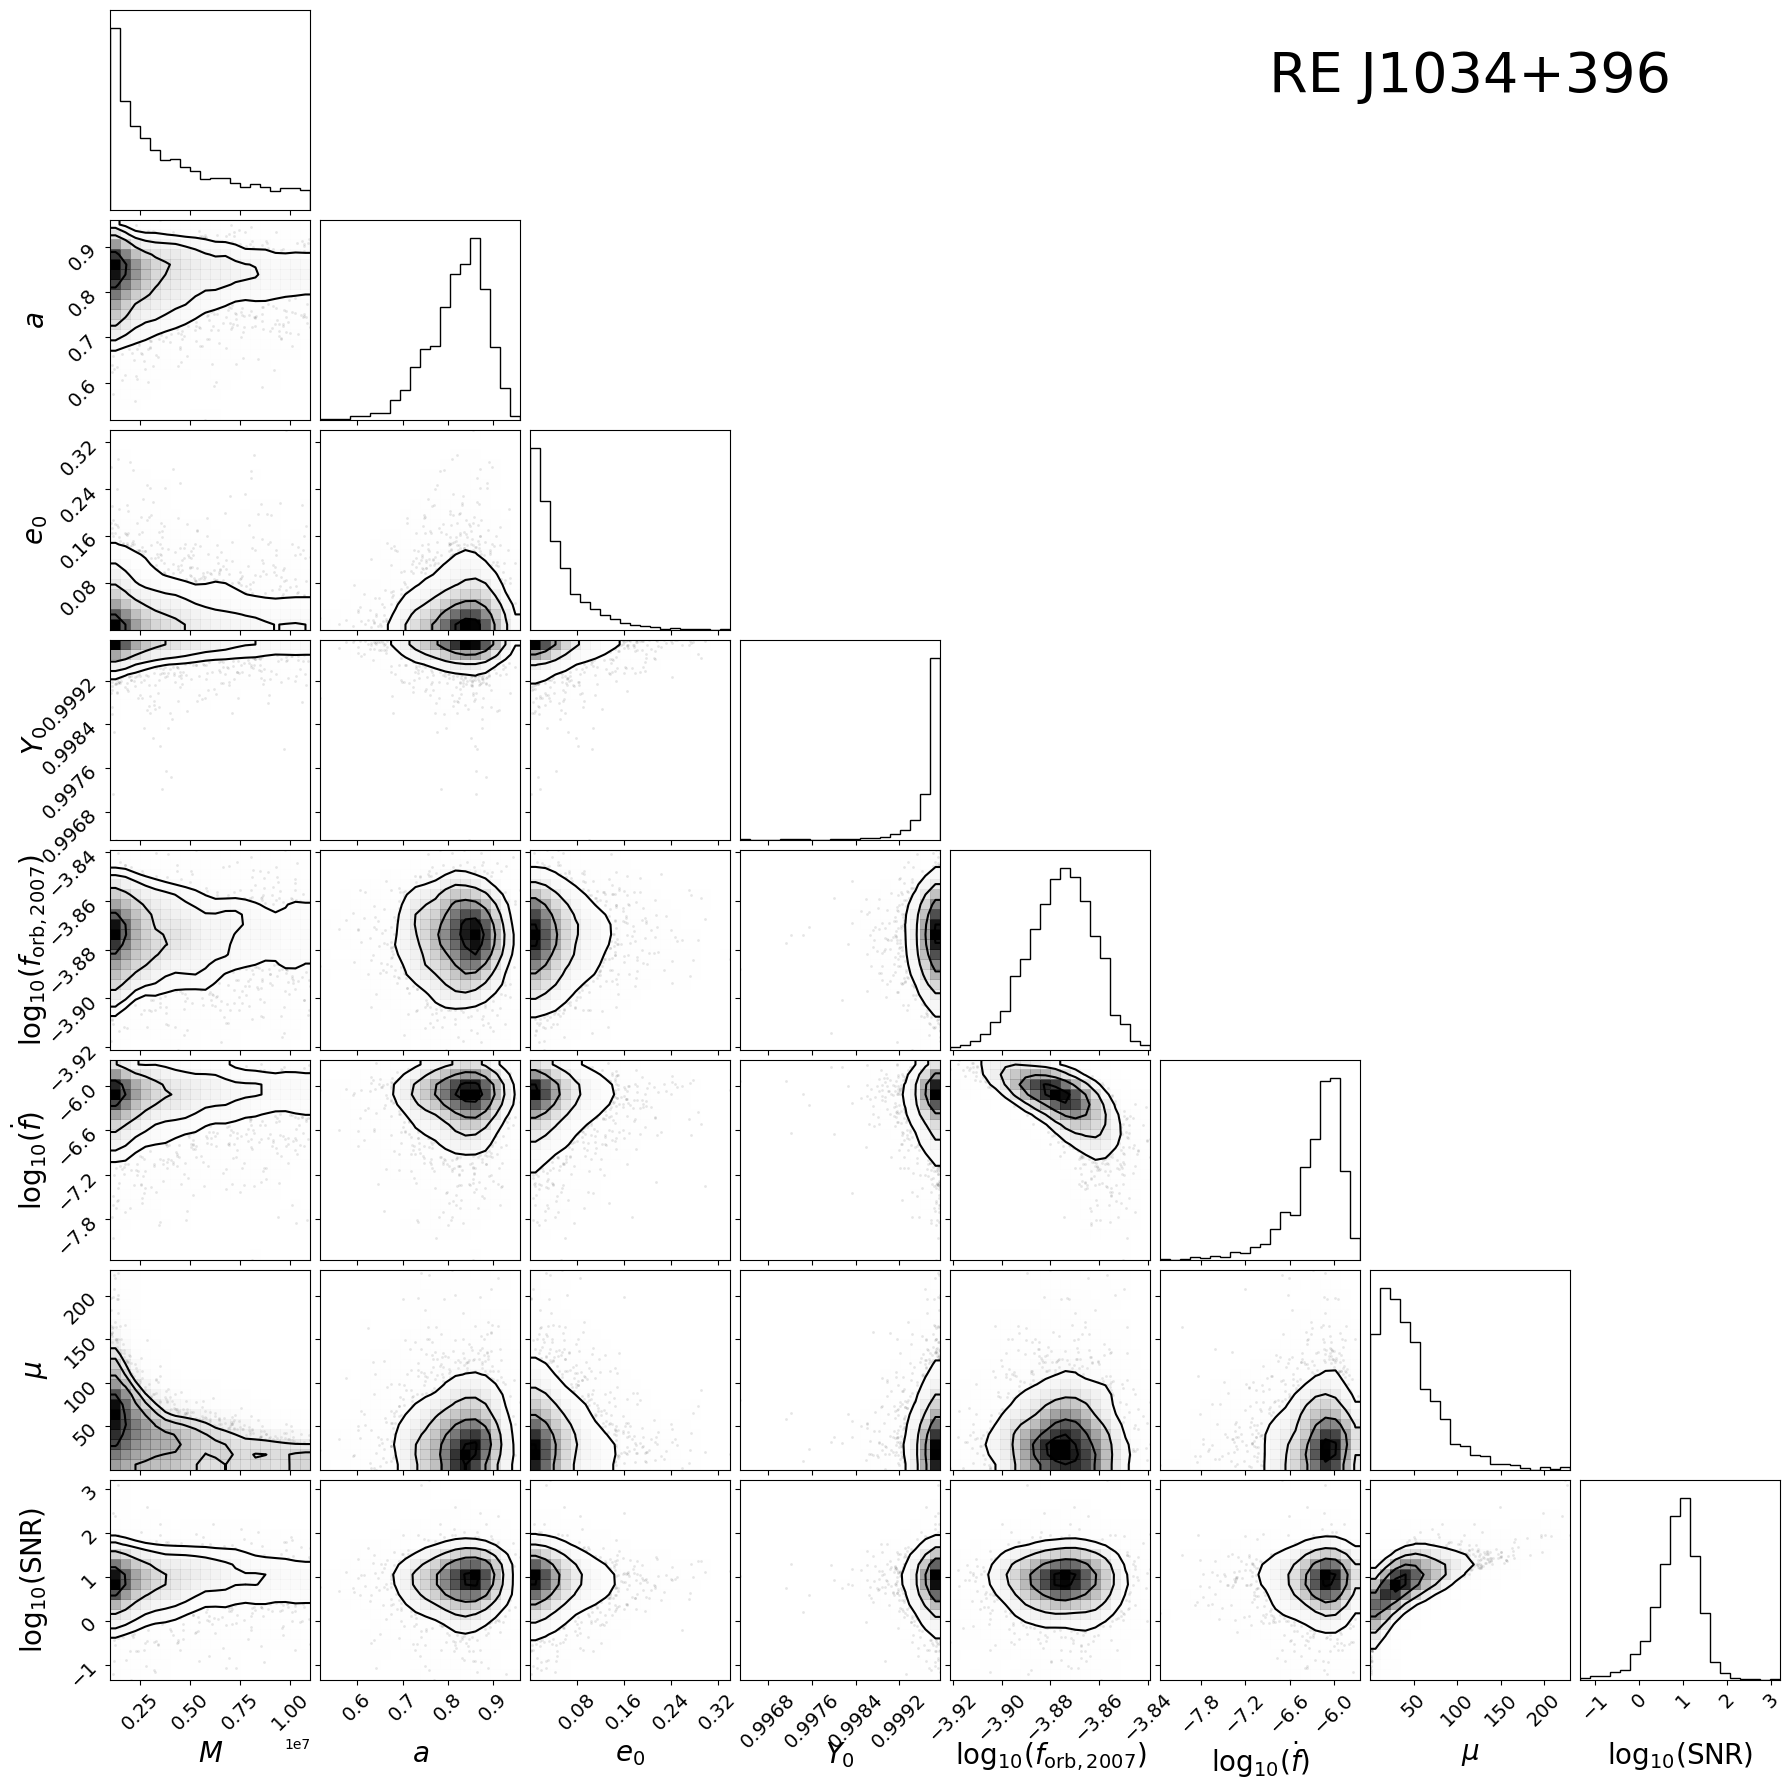

In [109]:
#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
np.random.seed(42)
from scipy.stats import expon, norm, uniform, skewnorm
from getdist import plots, MCSamples
import numpy as np

#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
np.random.seed(42)
from scipy.stats import expon, norm, uniform, skewnorm

#number of samples drawn
N = 2000

#redshifted MBH mass #####################################
#M_samples = norm.rvs(size=N,loc=2.5e6,scale=0.7e6)*(1+z)

log10M_samples = 6+uniform.rvs(size=N)*(1+z)

M_samples = 10**log10M_samples

plt.hist(M_samples)
plt.show()

#spin ####################################################
mean = 0.9
scale = 0.1

a_samples = skewnorm.rvs(-4,size=N,loc=mean,scale=scale) # uncertainty: Gamma[mean=0.9,var=0.01]
#a_samples = 1.9*(0.5-uniform.rvs(size=N))
#a_samples = a_samples[a_samples<1]
plt.hist(a_samples)
plt.show()

#eccentricity ############################################
mean = 0.1
scale = 0.05

e0_samples = expon.rvs(size=N,scale=scale,loc=1e-3) # uncertainty: Gamma[mean=0.1,var=0.001]
#e0_samples = e0_samples[e0_samples>0.0]
#e0_samples = np.zeros(N)

plt.hist(e0_samples)
plt.show()

#inc ######################################################
scale = 0.01

inc = expon.rvs(size=N,scale=scale,loc=0.01)
Y0_samples = np.cos(inc)

plt.hist(inc)
plt.show()

#periodicity ##############################################

detection1 = 2007
detection2 = 2018

T_detector_det1 = norm.rvs(size=N,loc=3730,scale=130) #in seconds, Vol 455| 18 September 2008| doi:10.1038/nature07277
plt.hist(T_detector_det1)
plt.show()

f1_samples = 1/(2*T_detector_det1) #Hz


T_detector_det2 = norm.rvs(size=N,loc=3550,scale=80) #in seconds, https://arxiv.org/pdf/2005.05857.pdf
plt.hist(T_detector_det2)
plt.show()

f2_samples = 1/(2*T_detector_det2) #Hz

plt.hist(f1_samples)
plt.hist(f2_samples)
plt.show()

#sky location #############################################

qS = 159*np.pi/180 #159 degrees from Newton-XMM open data
phiS = 40*np.pi/180 #40 degrees from Newton-XMM open data
qK = 0.2 #randomized
phiK = 0.4 #randomized

samples_bool = []

for i in range(len(M_samples)):
    if f1_samples[i] < f2_samples[i]:
        samples_bool.append(True)
    else:
        samples_bool.append(False)

M_samples = M_samples[samples_bool]
a_samples = a_samples[samples_bool]
e0_samples = e0_samples[samples_bool]
Y0_samples = Y0_samples[samples_bool]
f1_samples = f1_samples[samples_bool]
f2_samples = f2_samples[samples_bool]

f_dot_samples = (f2_samples - f1_samples)/((detection2-detection1))

filename = 'Msamples_OOM'

SNR = np.loadtxt(f'SNR_{filename}.txt')
mu_samples = np.loadtxt(f'mu_{filename}.txt')

M_samples = M_samples[SNR!=0]
a_samples = a_samples[SNR!=0]
e0_samples = e0_samples[SNR!=0]
Y0_samples = Y0_samples[SNR!=0]
f1_samples = f1_samples[SNR!=0]
f2_samples = f2_samples[SNR!=0]
f_dot_samples = f_dot_samples[SNR!=0]
mu_samples = mu_samples[SNR!=0]
SNR = SNR[SNR!=0]

samples = np.stack(((M_samples),(a_samples),(e0_samples),
                    (Y0_samples),(log10f1_samples),
                    (log10fdot_samples),mu_samples[SNR!=0.0],np.log10(SNR[SNR!=0.0])[:len(mu_samples)]),axis=1)

figure = corner.corner(samples,labels=["$M$", r"$a$", r"$e_0$", r"$Y_0$", r"$\log_{10}(f_{\rm orb,2007})$","$\log_{10}(\dot{f})$", r"$\mu$",r"$\log_{10}(\rm SNR)$"],
                       show_title=True,label_kwargs=dict(fontsize=20),smooth=True)

figure.gca().annotate("RE J1034+396",
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(-100, -50), textcoords="offset points",
                      ha="right", va="top",fontsize= 40)

for ax in figure.get_axes():
      #ax.tick_params(axis='both', which='major', labelsize=14)
      #ax.tick_params(axis='both', which='minor', labelsize=12)    
      ax.tick_params(axis='both', labelsize=14)

figure.savefig(f'SNR_{filename}.pdf',dpi=300,bbox_inches='tight')

#figure = corner.corner(SNR,labels=[r"SNR"],show_titles=True, title_kwargs={"fontsize":12},smooth=True)
#figure.savefig(f'SNR1D_{filename}.png',dpi=300,bbox_inches='tight')

#plt.figure(figsize=(7,5))
#plt.xlabel('LISA SNR')
#plt.hist(SNR,color='r',alpha=0.5)
#plt.yscale('log')
#plt.savefig('SNR_REJ1034396.png',dpi=300,bbox_inches='tight')

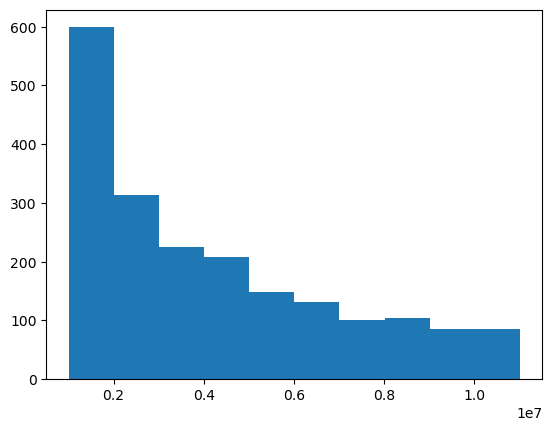

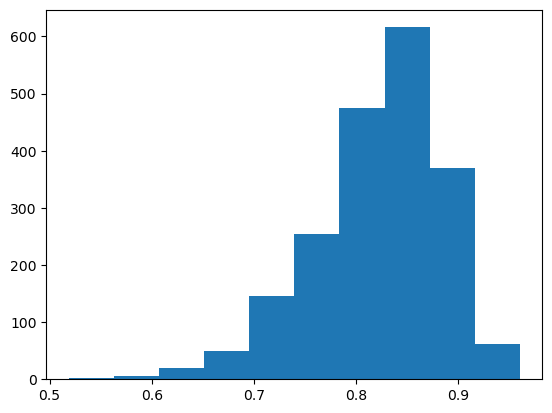

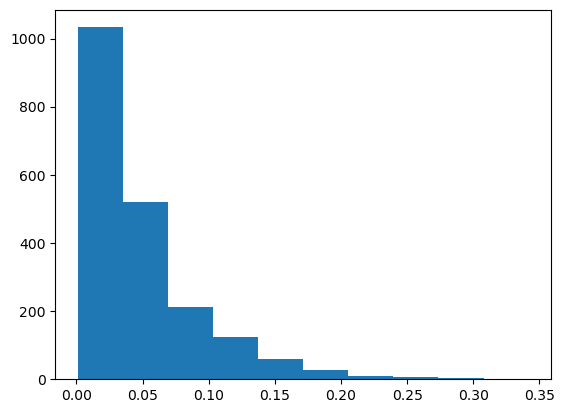

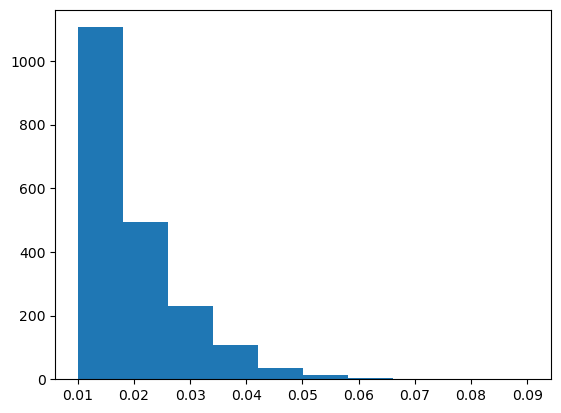

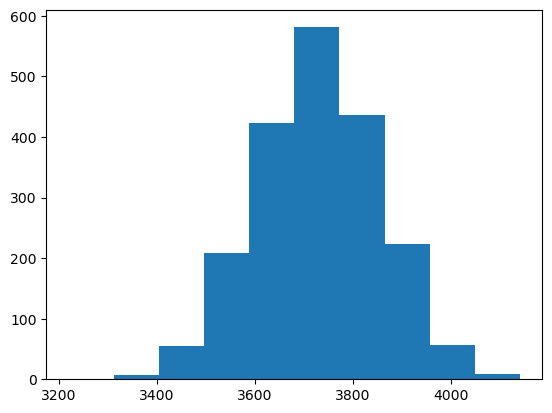

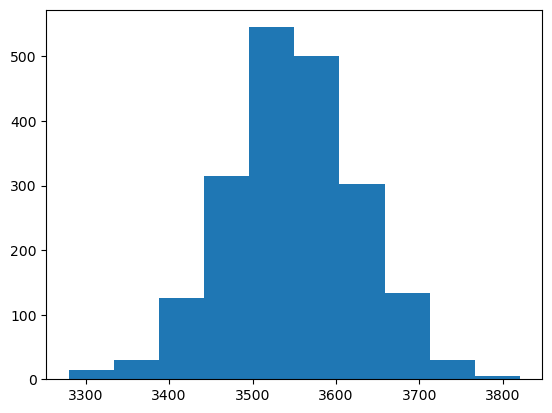

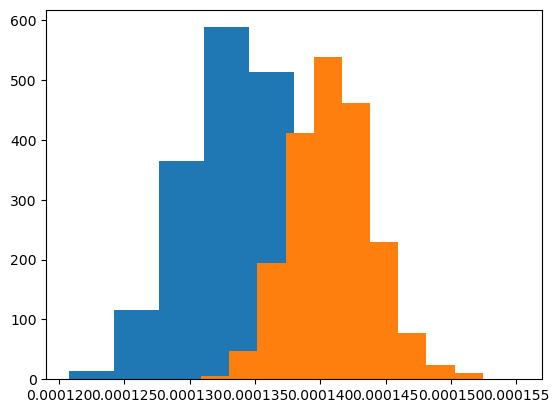

Removed no burn in
Removed no burn in


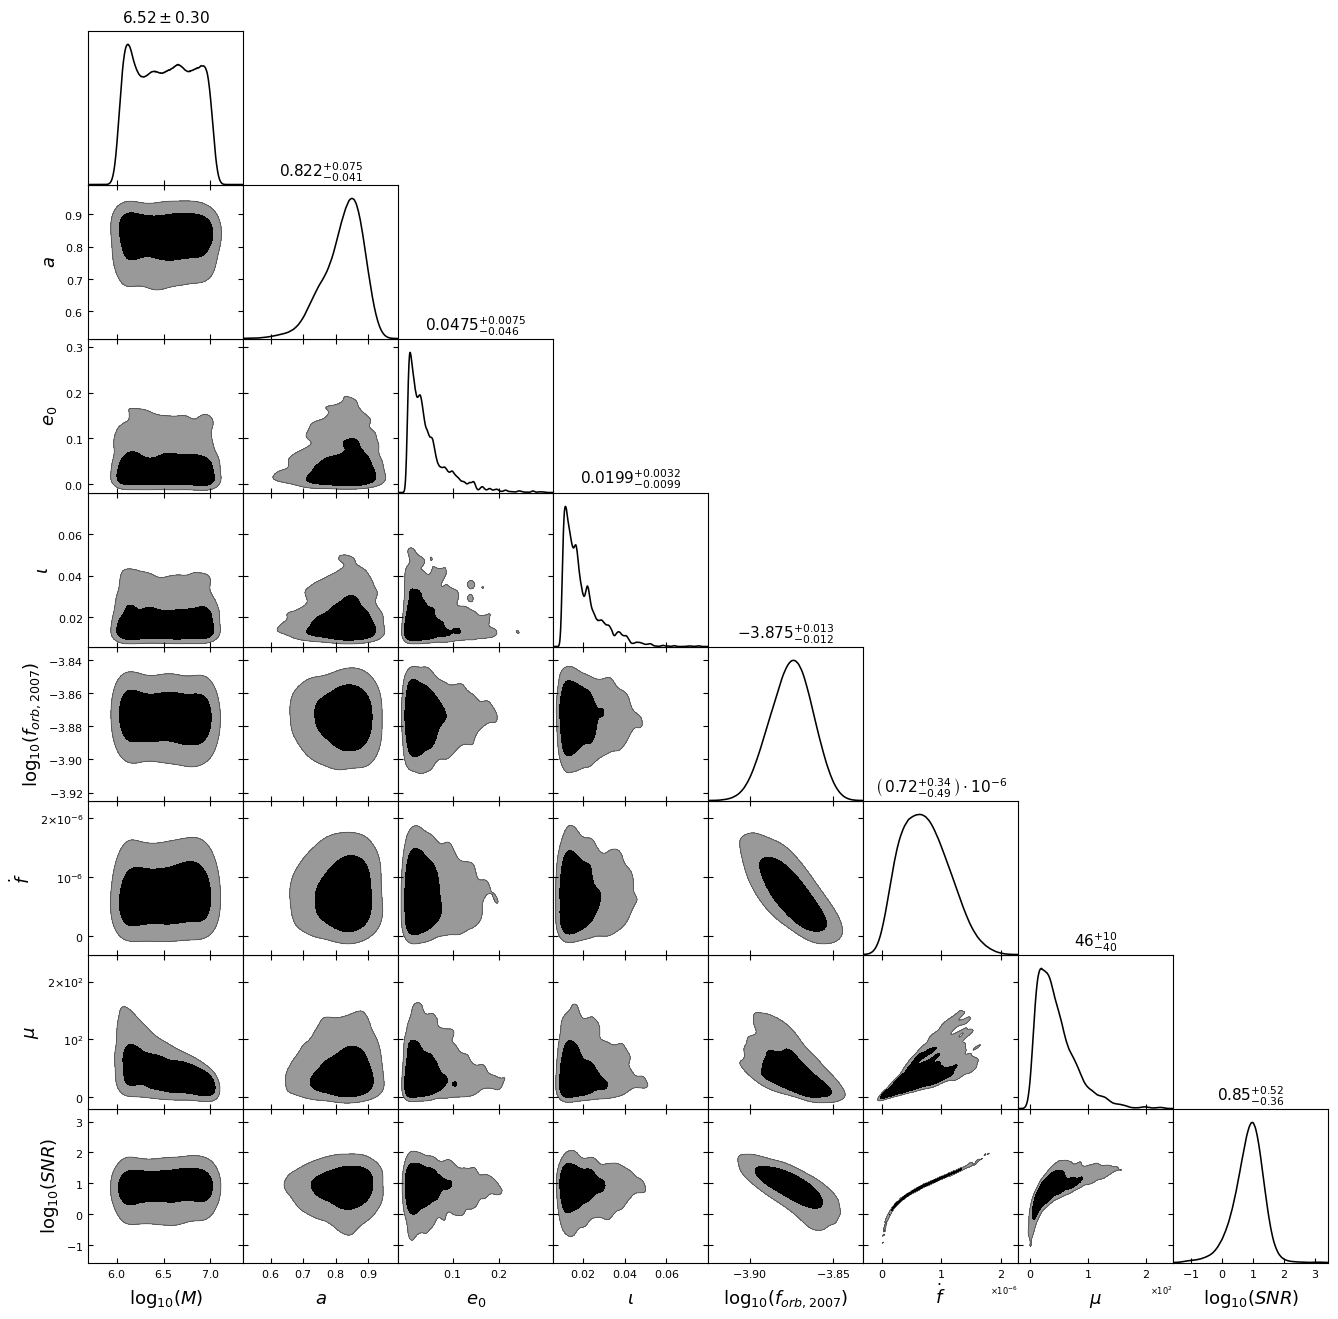

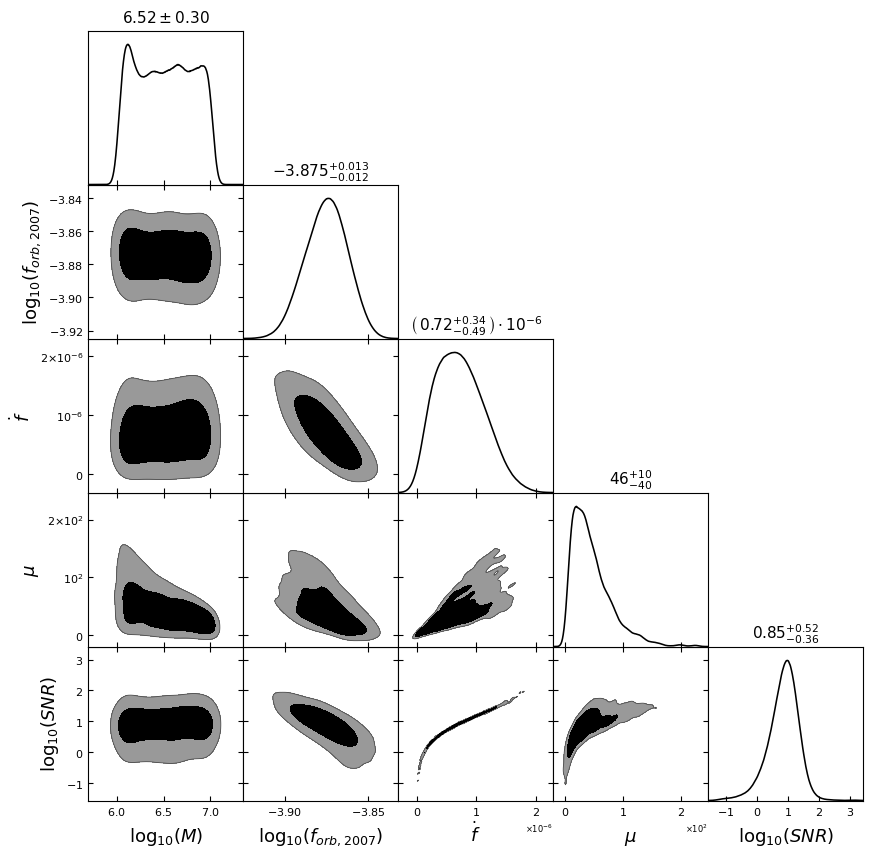

In [110]:
#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
np.random.seed(42)
from scipy.stats import expon, norm, uniform, skewnorm
from getdist import plots, MCSamples
import numpy as np

#source parameters, refer to https://nxsa.esac.esa.int/nxsa-web/#search
np.random.seed(42)
from scipy.stats import expon, norm, uniform, skewnorm

#number of samples drawn
N = 2000

#redshifted MBH mass #####################################
#M_samples = norm.rvs(size=N,loc=2.5e6,scale=0.7e6)*(1+z)

log10M_samples = 6+uniform.rvs(size=N)*(1+z)

M_samples = 10**log10M_samples

plt.hist(M_samples)
plt.show()

#spin ####################################################
mean = 0.9
scale = 0.1

a_samples = skewnorm.rvs(-4,size=N,loc=mean,scale=scale) # uncertainty: Gamma[mean=0.9,var=0.01]
#a_samples = 1.9*(0.5-uniform.rvs(size=N))
#a_samples = a_samples[a_samples<1]
plt.hist(a_samples)
plt.show()

#eccentricity ############################################
mean = 0.1
scale = 0.05

e0_samples = expon.rvs(size=N,scale=scale,loc=1e-3) # uncertainty: Gamma[mean=0.1,var=0.001]
#e0_samples = e0_samples[e0_samples>0.0]
#e0_samples = np.zeros(N)

plt.hist(e0_samples)
plt.show()

#inc ######################################################
scale = 0.01

inc = expon.rvs(size=N,scale=scale,loc=0.01)
Y0_samples = np.cos(inc)

plt.hist(inc)
plt.show()

#periodicity ##############################################

detection1 = 2007
detection2 = 2018

T_detector_det1 = norm.rvs(size=N,loc=3730,scale=130) #in seconds, Vol 455| 18 September 2008| doi:10.1038/nature07277
plt.hist(T_detector_det1)
plt.show()

f1_samples = 1/(2*T_detector_det1) #Hz


T_detector_det2 = norm.rvs(size=N,loc=3550,scale=80) #in seconds, https://arxiv.org/pdf/2005.05857.pdf
plt.hist(T_detector_det2)
plt.show()

f2_samples = 1/(2*T_detector_det2) #Hz

plt.hist(f1_samples)
plt.hist(f2_samples)
plt.show()

#sky location #############################################

qS = 159*np.pi/180 #159 degrees from Newton-XMM open data
phiS = 40*np.pi/180 #40 degrees from Newton-XMM open data
qK = 0.2 #randomized
phiK = 0.4 #randomized


samples_bool = []

for i in range(len(M_samples)):
    if f1_samples[i] < f2_samples[i]:
        samples_bool.append(True)
    else:
        samples_bool.append(False)

M_samples = M_samples[samples_bool]
a_samples = a_samples[samples_bool]
e0_samples = e0_samples[samples_bool]
Y0_samples = Y0_samples[samples_bool]
f1_samples = f1_samples[samples_bool]
f2_samples = f2_samples[samples_bool]

f_dot_samples = (f2_samples - f1_samples)/((detection2-detection1))

filename = 'Msamples_OOM'

SNR = np.loadtxt(f'SNR_{filename}.txt')
mu_samples = np.loadtxt(f'mu_{filename}.txt')

M_samples = M_samples[SNR!=0]
a_samples = a_samples[SNR!=0]
e0_samples = e0_samples[SNR!=0]
Y0_samples = Y0_samples[SNR!=0]
f1_samples = f1_samples[SNR!=0]
f2_samples = f2_samples[SNR!=0]
f_dot_samples = f_dot_samples[SNR!=0]
mu_samples = mu_samples[SNR!=0]
SNR = SNR[SNR!=0]

samples = np.stack((np.log10(M_samples),a_samples,e0_samples,np.arccos(Y0_samples),np.log10(f1_samples),f_dot_samples,mu_samples,np.log10(SNR)),axis=1)

samples = MCSamples(samples=samples,names=["log10M", "a", "e_0", "inc", "f_{orb,2007}","\dot{f}", "\mu", "\log_{10}(SNR)"],
                   labels=["\log_{10}(M)", "a", "e_0", "\iota", "\log_{10}(f_{orb,2007})","\dot{f}", "\mu", "\log_{10}(SNR)"],)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 14
g.settings.axes_labelsize = 16
g.settings.title_limit_labels=False
g.settings.axis_tick_powerlimits=[-3,2]
g.settings.linewidth=2
g.settings.tight_layout=True
g.settings.scaling=True

g.triangle_plot([samples], filled=True, contour_colors=['black'],title_limit=1)
g.export('REJ1034+396.pdf')

################################################


samples = np.stack((np.log10(M_samples),np.log10(f1_samples),f_dot_samples,mu_samples,np.log10(SNR)),axis=1)

samples = MCSamples(samples=samples,names=["log10M", "f_{orb,2007}","\dot{f}", "\mu", "\log_{10}(SNR)"],
                   labels=["\log_{10}(M)", "\log_{10}(f_{orb,2007})","\dot{f}", "\mu", "\log_{10}(SNR)"],)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 14
g.settings.axes_labelsize = 16
g.settings.title_limit_labels=False
g.settings.axis_tick_powerlimits=[-3,2]
g.settings.linewidth=2
g.settings.tight_layout=True
g.settings.scaling=True

g.triangle_plot([samples], filled=True, contour_colors=['black'],title_limit=1)
g.export('REJ1034+396_marginalized.pdf')

In [111]:
print(np.mean((SNR)))
print(np.std(SNR))

13.746958019821614
50.49226485490477


### Merger rate -- Calculating the final (end of LISA observation) semi-latus rectum of the EMRI

### Evaluation Cell

In [ ]:
filename = 'all_vary_ncol2_2037_inc'

SNR = np.loadtxt(f'SNR_{filename}.txt')

p0_LISA_range = np.loadtxt('p0_LISA_all_vary_ncol2_2037_inc.txt')
p0_LISA_range = p0_LISA_range[SNR!=0]

print(np.mean(p0_LISA_range))
print(np.std(p0_LISA_range))

#plt.figure(figsize=(10,5))

from tqdm import tqdm 

final_p = []

for i in tqdm(range(len(p0_LISA_range))):
    M = M_samples[i]
    a = a_samples[i]
    e0 = e0_samples[i]
    Y0 = Y0_samples[i]
    mu = mu_samples[i]
    p0 = p0_LISA_range[i]

    dist = getdist(z)

    qS = qS
    phiS = phiS
    qK = qK
    phiK = phiK
    
    trajectory = traj(M, mu, a, p0, e0, Y0, T=4, max_init_len=int(1e6))
    
    final_p.append(trajectory[1][-1])
    
    #plt.plot(trajectory[0]/YRSID_SI,trajectory[1],c='r',alpha=0.1)

plt.xlabel('time in LISA band (yrs)')
plt.ylabel('separation $p$')
plt.show()

np.savetxt(f'final_p_LISA_{filename}.txt',final_p)

In [112]:
final_p = np.loadtxt('final_p_LISA_all_vary_ncol2_2037_inc.txt')
np.mean(final_p)

18.388750891543747

0.045730341687486 13.701227678134128


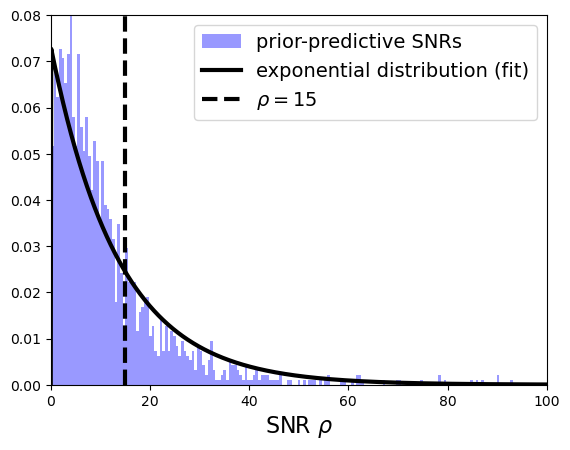

In [101]:
from scipy.stats import expon, gamma
from scipy.special import gamma as ssgamma

loc,scale = expon.fit(SNR)

#alpha, loc, beta = gamma.fit(SNR)

print(loc,scale)
#print(alpha,loc,beta)

SNR_cutoff = 15

#x = expon.rvs(scale=np.std(SNR),size=10000)
#plt.hist(expon.rvs(loc=loc,scale=scale,size=len(SNR)),density=True,bins=100,color='grey')
plt.hist(SNR,density=True,bins=3000,color='blue',alpha=0.4,label='prior-predictive SNRs')
plt.plot(np.linspace(0.0,100,1000),expon.pdf(np.linspace(0.0,100,1000),loc=loc,scale=scale),c='black',linewidth=3,label='exponential distribution (fit)')
#plt.plot(np.linspace(0.0,100,1000),beta**alpha*np.linspace(0.0,100,1000)**(alpha-1)*np.exp(-beta*np.linspace(0.0,100,1000))/ssgamma(alpha),c='red',linewidth=3,label='Gamma distribution (fit)')
plt.plot(SNR_cutoff*np.ones(100),np.linspace(0.0,0.1,100),'k--',linewidth=3,label=r'$\rho = 15$')
#plt.xscale('log')
plt.xlim([0.0,100])
plt.ylim([0.0,0.08])
plt.legend(fontsize=14)
plt.xlabel(r'SNR $\rho$',fontsize=16)
plt.savefig('REJ1034+396_SNR_fit.pdf',dpi=300,bbox_inches='tight')
plt.show()

### Detection probability (SNR > 15)

In [113]:
SNR_cutoff = 10

loc,scale = expon.fit(SNR)

def exponential(x,loc,scale):
    return 1/scale*np.exp(-1/scale*(x-loc))

from scipy.integrate import quad

#probability
detection_prob, _ = quad(exponential,SNR_cutoff,np.inf,args = (loc,scale))

print(detection_prob)

SNR_cutoff = 12

loc,scale = expon.fit(SNR)

def exponential(x,loc,scale):
    return 1/scale*np.exp(-1/scale*(x-loc))

from scipy.integrate import quad

#probability
detection_prob, _ = quad(exponential,SNR_cutoff,np.inf,args = (loc,scale))

print(detection_prob)

SNR_cutoff = 15

loc,scale = expon.fit(SNR)

def exponential(x,loc,scale):
    return 1/scale*np.exp(-1/scale*(x-loc))

from scipy.integrate import quad

#probability
detection_prob, _ = quad(exponential,SNR_cutoff,np.inf,args = (loc,scale))

print(detection_prob)

0.4835870585616252
0.41790704904972514
0.33572774746798584


In [14]:
np.corrcoef(np.arccos(Y0_samples),mu_samples)

array([[1.        , 0.01769858],
       [0.01769858, 1.        ]])